# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder (1 mark)

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
os.chdir("/content/drive/My Drive/Colab Notebooks/Python/Lab/Lab 10")

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [ ]:
import numpy as np
data = np.load("images.npy", allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)

Image index number:  146


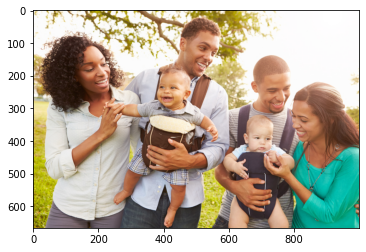

In [7]:
from matplotlib import pyplot as plt
img_num=np.random.randint(0,data.shape[0])
plt.imshow(data[img_num][0])
print('Image index number: ',img_num)

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [11]:
X_train.shape

(409, 224, 224, 3)

In [12]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.96862745  0.97647059  0.93725491]
  [ 0.94509804  0.88235295  0.79607844]
  [ 0.71764708  0.54509807  0.0196079 ]
  ...
  [ 1.          0.98431373  0.99215686]
  [ 0.98431373  0.98431373  0.98431373]
  [ 0.99215686  0.99215686  0.99215686]]

 [[ 0.99215686  0.96078432  0.96862745]
  [ 0.77254903  0.63137257  0.30196083]
  [ 0.81176472  0.67058825  0.27058828]
  ...
  [ 0.99215686  0.97647059  0.98431373]
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.98431373  0.98431373  0.98431373]]

 [[ 0.93725491  0.96078432  0.95294118]
  [ 0.56862748  0.41960788 -0.47450978]
  [ 0.9137255   0.73333335  0.36470592]
  ...
  [ 1.          0.98431373  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]]

 ...

 [[ 0.30196083  0.10588241 -0.64705884]
  [ 0.17647064  0.02745104 -0.92941177]
  [-0.24705881 -0.24705881 -0.96862745]
  ...
  [-0.34901959  0.65490198  0.45882356]
  [-0.39607841  0.60784316  0.45882356]
  [-0.33333331  0.62352943  0.47450984]]

 [

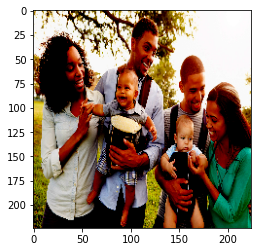

In [13]:
from matplotlib import pyplot
n = 146
print(X_train[n])
pyplot.imshow(X_train[n])

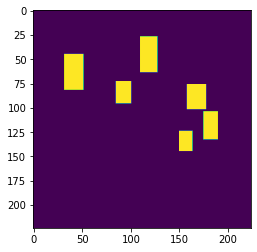

In [14]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [ ]:
HEIGHT_CELLS = 28
WIDTH_CELLS = 28
alpha = 1.0

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, Concatenate, UpSampling2D, Conv2D, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=alpha, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable

    block13 = model.get_layer("conv_pw_13_relu").output
    x = block13

    # Upsampling from block 13 to block 12
    x = Conv2DTranspose(int(1024 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  
    block12 = model.get_layer("conv_pw_12_relu").output
    x = Concatenate()([x, block12])
    x = Conv2D(1024, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 12 to block 11
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block11 = model.get_layer("conv_pw_11_relu").output
    x = Concatenate()([x, block11])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 11 to block 10
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block10 = model.get_layer("conv_pw_10_relu").output
    x = Concatenate()([x, block10])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    # Upsampling from block 10 to block 9
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block9 = model.get_layer("conv_pw_9_relu").output
    x = Concatenate()([x, block9])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    # Upsampling from block 9 to block 8
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block8 = model.get_layer("conv_pw_8_relu").output
    x = Concatenate()([x, block8])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   

    # Upsampling from block 8 to block 7
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block7 = model.get_layer("conv_pw_7_relu").output
    x = Concatenate()([x, block7])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    # Upsampling from block 7 to block 6
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block6 = model.get_layer("conv_pw_6_relu").output
    x = Concatenate()([x, block6])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   

    # Upsampling from block 6 to block 5
    x = Conv2DTranspose(int(256 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block5 = model.get_layer("conv_pw_5_relu").output
    x = Concatenate()([x, block5])
    x = Conv2D(256, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    # Upsampling from block 5 to block 4
    x = Conv2DTranspose(int(256 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block4 = model.get_layer("conv_pw_4_relu").output
    x = Concatenate()([x, block4])
    x = Conv2D(256, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 4 to block 3
    x = Conv2DTranspose(int(128 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block3 = model.get_layer("conv_pw_3_relu").output
    x = Concatenate()([x, block3])
    x = Conv2D(128, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 3 to block 2
    x = Conv2DTranspose(int(128 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block2 = model.get_layer("conv_pw_2_relu").output
    x = Concatenate()([x, block2])
    x = Conv2D(128, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 2 to block 1
    x = Conv2DTranspose(int(64 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block1 = model.get_layer("conv_pw_1_relu").output
    x = Concatenate()([x, block1])
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 1 to conv 1
    x = Conv2DTranspose(int(32 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv1 = model.get_layer("conv1_relu").output
    x = Concatenate()([x, conv1])
    x = Conv2D(32, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(int(32 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    

    # Adding below layer for final output
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((224, 224))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [19]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(False)

# Print summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [ ]:
model.compile(loss=loss, optimizer='Adam', metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [24]:
model.fit(x=X_train, y=masks, epochs=16, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/16
409/409 [==============================] - ETA: 0s - loss: 1.1417 - dice_coefficient: 0.4965
Epoch 00001: loss improved from inf to 1.14172, saving model to model-1.14.h5
409/409 [==============================] - 456s 1s/step - loss: 1.1417 - dice_coefficient: 0.4965 - lr: 0.0010
Epoch 2/16
409/409 [==============================] - ETA: 0s - loss: 0.8600 - dice_coefficient: 0.5917
Epoch 00002: loss improved from 1.14172 to 0.85999, saving model to model-0.86.h5
409/409 [==============================] - 460s 1s/step - loss: 0.8600 - dice_coefficient: 0.5917 - lr: 0.0010
Epoch 3/16
409/409 [==============================] - ETA: 0s - loss: 0.7761 - dice_coefficient: 0.6222
Epoch 00003: loss improved from 0.85999 to 0.77606, saving model to model-0.78.h5
409/409 [==============================] - 453s 1s/step - loss: 0.7761 - dice_coefficient: 0.6222 - lr: 0.0010
Epoch 4/16
409/409 [==============================] - ETA: 0s - loss: 0.7261 - dice_coefficient: 0.6423
Epoch 000

### Get the predicted mask for a sample image   (3 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


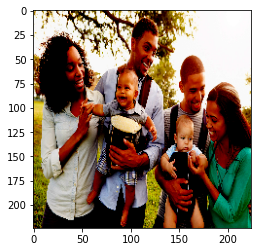

In [25]:
n = 146
sample_image = X_train[n]
pyplot.imshow(sample_image)

### Impose the mask on the image (3 marks)

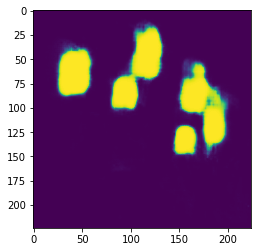

In [26]:
resized_sample_image = np.expand_dims(sample_image, axis=0)
mask = model.predict(resized_sample_image)
mask = np.reshape(mask, (224,224))
pyplot.imshow(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


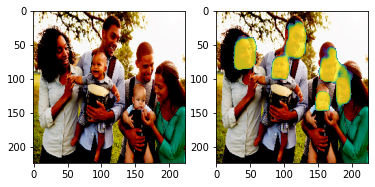

In [27]:
masked = np.ma.masked_where(mask < 0.1, mask)

pyplot.figure()
pyplot.subplot(1,2,1)
pyplot.imshow(sample_image)
pyplot.subplot(1,2,2)
pyplot.imshow(sample_image)
pyplot.imshow(masked, alpha=0.8)
pyplot.show()